## Importing libraries

In [255]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import LSTM, Flatten

from google.colab import drive
drive.mount('/content/drive')

# To get reproducible results
from numpy.random import seed 
seed(0) 
tensorflow.random.set_seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [256]:
df = pd.read_csv('/content/drive/MyDrive/Biogas RMS project/Datasets/Lab dataset/reactor1_biogas.csv', index_col="day", usecols = ["day", "TS_actual", "VS_actual", "VS/TS", "reactor1"])
df.sort_index(inplace=True)
df.head()

,TS_actual,VS_actual,VS/TS,reactor1
day,,,,
0,369.5930,338.3879,0.915569,0
1,357.2494,326.3529,0.913516,100
2,344.9058,314.3179,0.911315,120
3,332.5622,302.2829,0.908951,100
4,320.2186,290.2479,0.906405,100


## Plotting the different values
This section takes a look at the trend in the biogas values, VS and TS values.

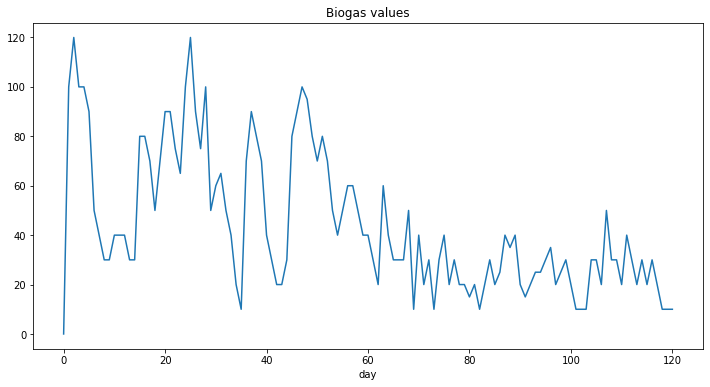

In [257]:
# Biogas values
df["reactor1"].plot(figsize=(12,6), title= "Biogas values")

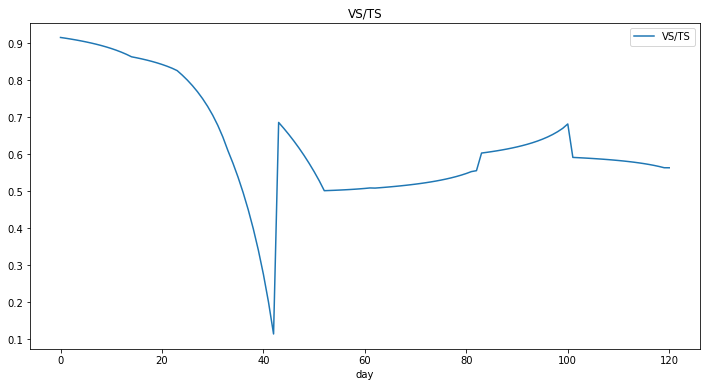

In [258]:
df[["VS/TS"]].plot(figsize=(12,6), legend=True, title = "VS/TS")

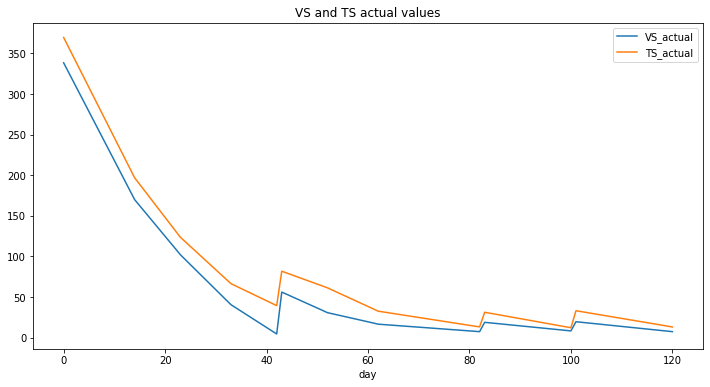

In [259]:
df[["VS_actual", "TS_actual"]].plot(figsize=(12,6), legend=True, title = "VS and TS actual values")

### Decomposing the plot
Using seasonal-decompose to find a trend, seasonal changes and noise in the plot.

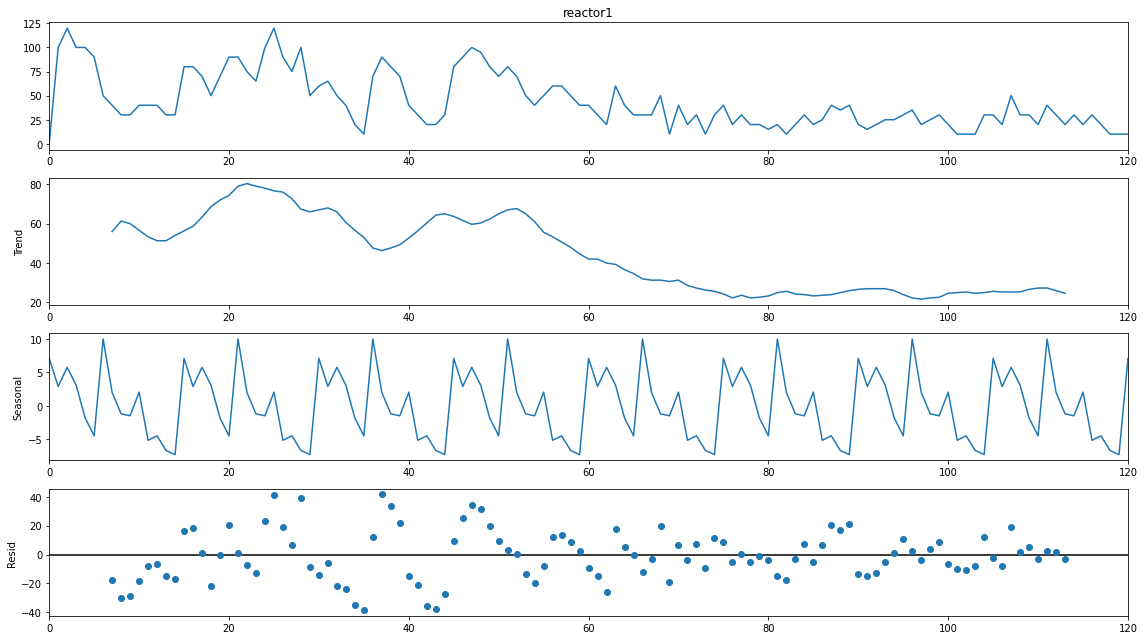

In [260]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(x= df['reactor1'],  period = 15, model='additive')
decompose_plot = results.plot();
decompose_plot.set_size_inches((16, 9))
# Tight layout to realign things
decompose_plot.tight_layout()
decompose_plot.show()

## Scaling the data
The train-test split needs to be done in a sequential manner, and not randomly.

In [261]:
# Using the MinMaxScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaler.fit(df)

scaled_dataset = scaler.transform(df)

## Generating sequences
To generate a series based input for our model.

In [262]:
def sequenceGenerator(dataset, sequenceSize=1):
  #Function that returns X and y from a given set of data points, where X is a set of sequences
    X = []
    y = []

    # using a sliding window to get values for the sequence. The value just after the sequnce is used as y
    for i in range(len(dataset)-sequenceSize-1):
        current_window = dataset[i:(i+sequenceSize), :]
        X.append(current_window)
        y.append(dataset[i+sequenceSize, -1])
        
    return np.array(X),np.array(y)

# Using the function to generate train and test sequences

# Defining the sequence size to be used.
sequence_size = 5
X, y = sequenceGenerator(scaled_dataset, sequence_size)
len(X)

115

## Splitting into train and test set
This needs to be done sequentially.

In [263]:
# Setting a fraction for train data
train_fraction = 0.7
train_size = (int)(len(X)*train_fraction)

# Splitting the train and test data
X_train = X[0:train_size]
y_train = y[0:train_size]

X_test = X[train_size :]
y_test = y[train_size :]

# Building LSTM models

## Input shape
LSTMs expect input array to be a 3D array: (batch_size, time_steps, seq_len)
* `batch_size` = Number of inputs in the training data
* `time_steps` = Number of historical datapoints being given
* `seq_len` = Number of features in a single historical datapoint

Example 1: If there are 2500 training sentences, with 50 words in each, with each word being encoded as an integer, then the input shape would be: `(2500, 50, 1)` 

So, for univariate analysis, the input shape will be:  
`(num_training_observations, sequence_size, 1)`

For multivariate analysis, the shape does not need to change.


## a) Single LSTM layer (64 neurons)

In [51]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17664     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 4s 293ms/step - loss: 1.0239 - val_loss: 0.6112
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.9195 - val_loss: 0.5616
Epoch 3/100
3/3 [==============================] - 0s 18ms/step - loss: 0.8272 - val_loss: 0.5184
Epoch 4/100
3/3 [==============================] - 0s 26ms/step - loss: 0.7687 - val_loss: 0.4766
Epoch 5/100
3/3 [==============================] - 0s 19ms/step - loss: 0.7206 - val_loss: 0.4448
Epoch 6/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6909 - val_loss: 0.4185
Epoch 7/100
3/3 [==============================] - 0s 19ms/step - loss: 0.6753 - val_loss: 0.4005
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6572 - val_loss: 0.3891
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.6421 - val_loss: 0.3825
Epoch 10/100
3/3 [==============================] - 0s 20ms/step - loss: 0.6219 - val_loss: 0.3805
Epoch 11/100
3/3 [

### Plotting the loss

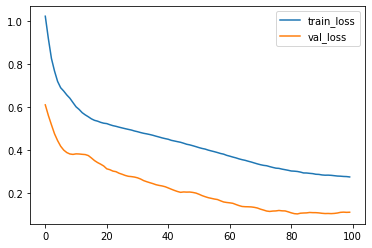

In [53]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 0s 5ms/step


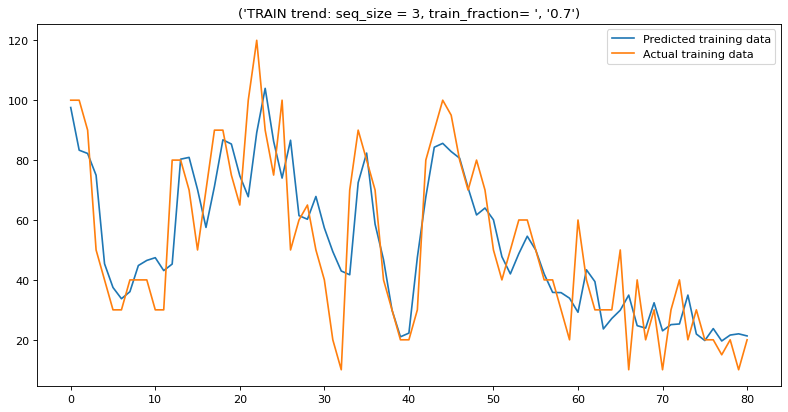

In [54]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 5ms/step


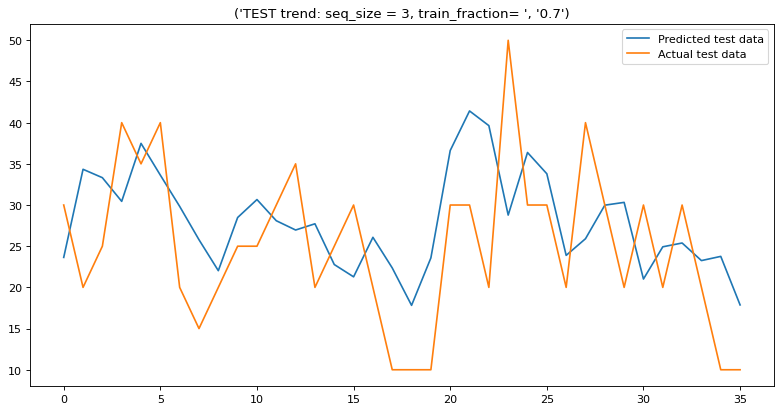

In [55]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

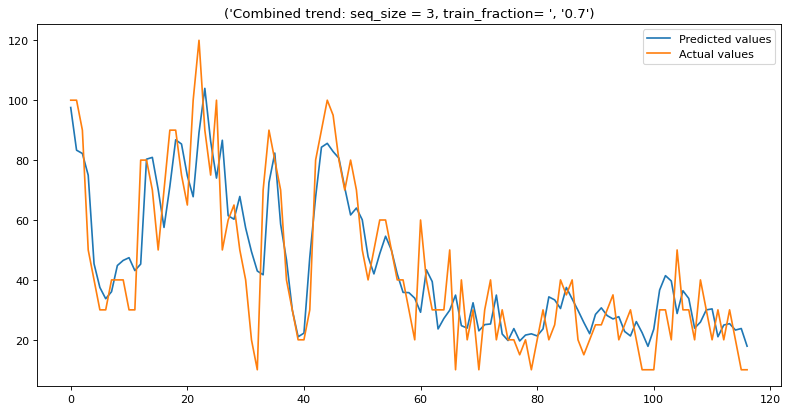

In [56]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [57]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.718 ,  0.028 ,  0.752


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [58]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  14.658 ,  9.328 ,  13.249


### Analysis
**1. Sequence size of 3, train size of 0.7**  
1. Trend is followed on the entire dataset. But there is a lag in the start of train data and lead in the test data.
2. r2 score:  0.718 ,  0.028 ,  0.752
3. RMSE:  14.658 ,  9.328 ,  13.249


## b) 1 LSTM + 1 Dense layer

In [119]:
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(20, activation="relu"))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 20)                2000      
                                                                 
 dense_9 (Dense)             (None, 20)                420       
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 2,441
Trainable params: 2,441
Non-trainable params: 0
_________________________________________________________________


In [120]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 3s 287ms/step - loss: 1.1116 - val_loss: 0.4331
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 1.0500 - val_loss: 0.4212
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9911 - val_loss: 0.4100
Epoch 4/100
3/3 [==============================] - 0s 18ms/step - loss: 0.9382 - val_loss: 0.3952
Epoch 5/100
3/3 [==============================] - 0s 18ms/step - loss: 0.8903 - val_loss: 0.3808
Epoch 6/100
3/3 [==============================] - 0s 26ms/step - loss: 0.8457 - val_loss: 0.3641
Epoch 7/100
3/3 [==============================] - 0s 17ms/step - loss: 0.8098 - val_loss: 0.3486
Epoch 8/100
3/3 [==============================] - 0s 18ms/step - loss: 0.7763 - val_loss: 0.3323
Epoch 9/100
3/3 [==============================] - 0s 18ms/step - loss: 0.7474 - val_loss: 0.3157
Epoch 10/100
3/3 [==============================] - 0s 18ms/step - loss: 0.7188 - val_loss: 0.2999
Epoch 11/100
3/3 [

### Plotting the loss

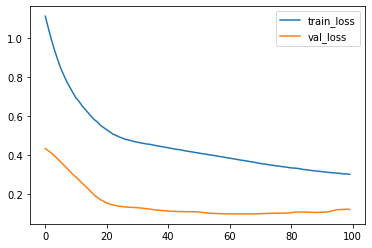

In [121]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 10ms/step


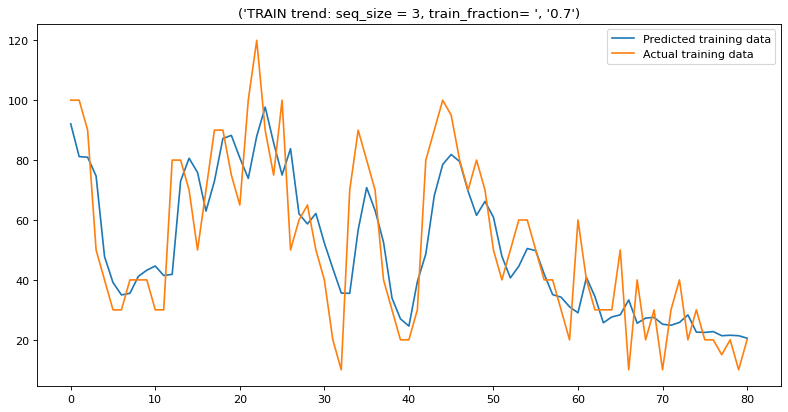

In [122]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 7ms/step


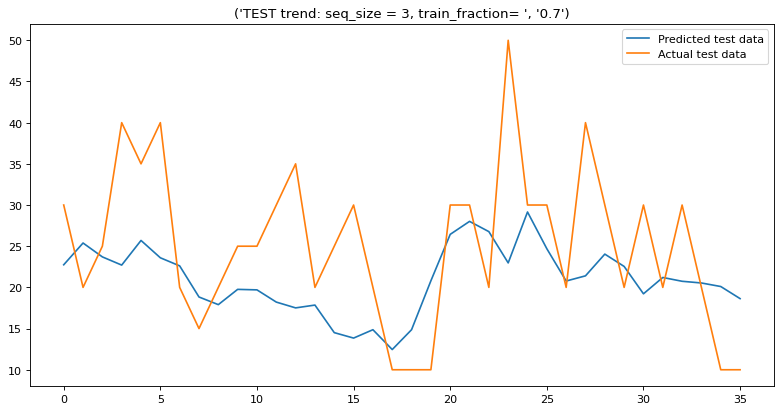

In [123]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

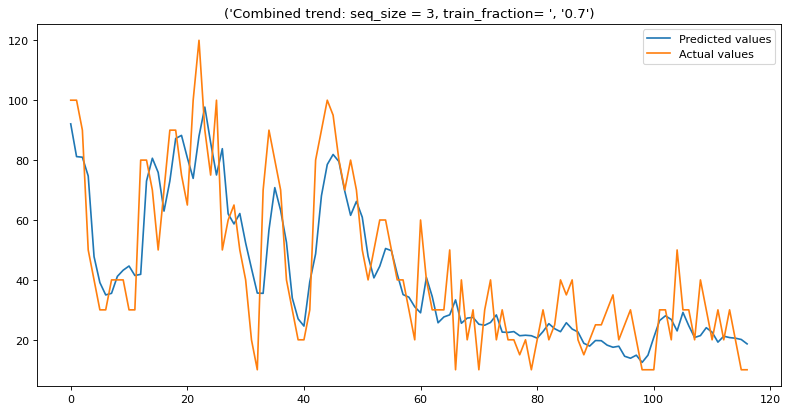

In [124]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [125]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.693 ,  -0.056 ,  0.73


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [126]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  15.298 ,  9.723 ,  13.824


### Analysis
**1. Sequence size of 3, train size of 0.7**
1. Train data has lag. Test data is just following the basic trend.
2. r2 score:  0.693 ,  -0.056 ,  0.73
3. RMSE:  15.298 ,  9.723 ,  13.824



## c) 2 LSTM layers 


In [196]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 5, 20)             2000      
                                                                 
 lstm_18 (LSTM)              (None, 20)                3280      
                                                                 
 dense_16 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


In [197]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 5s 410ms/step - loss: 1.0901 - val_loss: 0.5756
Epoch 2/100
3/3 [==============================] - 0s 22ms/step - loss: 1.0499 - val_loss: 0.5734
Epoch 3/100
3/3 [==============================] - 0s 22ms/step - loss: 1.0139 - val_loss: 0.5701
Epoch 4/100
3/3 [==============================] - 0s 23ms/step - loss: 0.9829 - val_loss: 0.5657
Epoch 5/100
3/3 [==============================] - 0s 23ms/step - loss: 0.9536 - val_loss: 0.5608
Epoch 6/100
3/3 [==============================] - 0s 24ms/step - loss: 0.9273 - val_loss: 0.5552
Epoch 7/100
3/3 [==============================] - 0s 25ms/step - loss: 0.9079 - val_loss: 0.5484
Epoch 8/100
3/3 [==============================] - 0s 23ms/step - loss: 0.8868 - val_loss: 0.5414
Epoch 9/100
3/3 [==============================] - 0s 23ms/step - loss: 0.8643 - val_loss: 0.5345
Epoch 10/100
3/3 [==============================] - 0s 22ms/step - loss: 0.8475 - val_loss: 0.5285
Epoch 11/100
3/3 [

### Plotting the loss

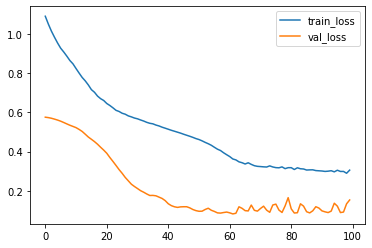

In [198]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 5ms/step


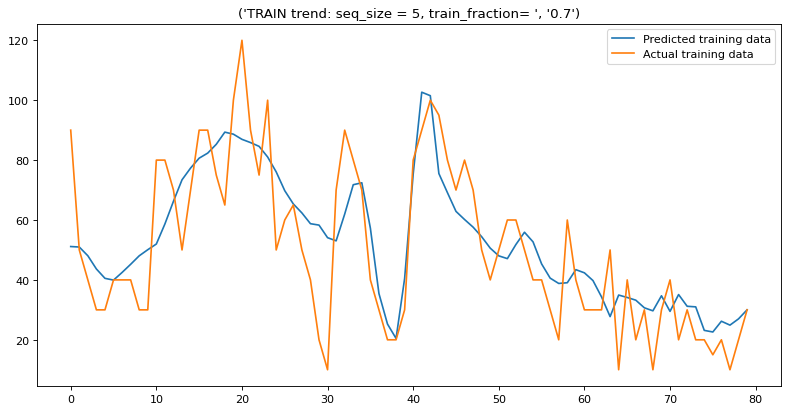

In [199]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 7ms/step


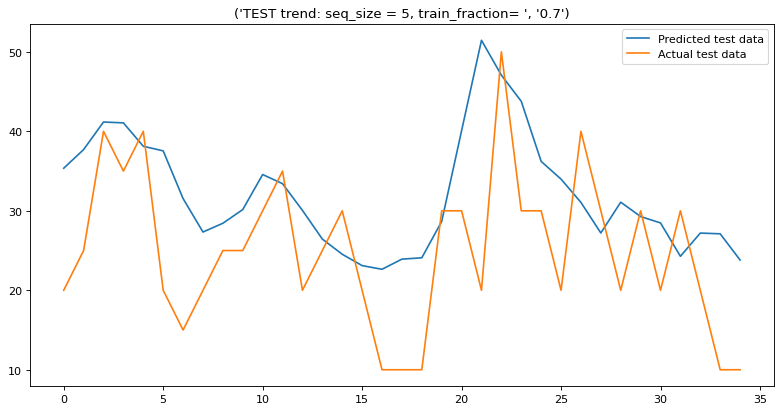

In [200]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

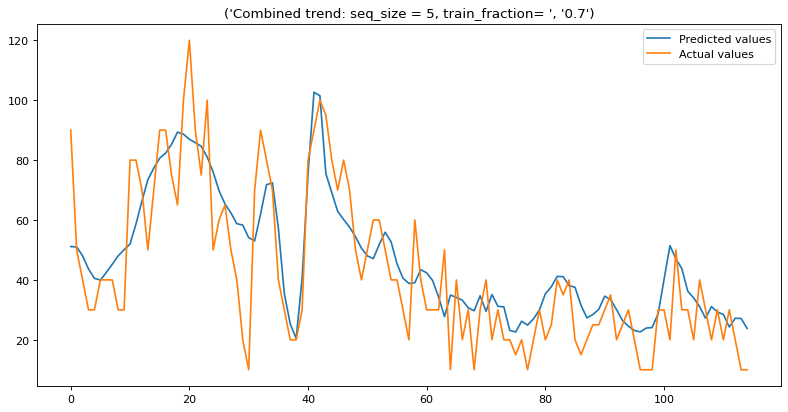

In [201]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [202]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.669 ,  -0.315 ,  0.696


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [203]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  15.396 ,  10.964 ,  14.194


### Analysis
**1. Sequence size of 5, train size of 0.7**
1. Very generalised values for the train set and sort of an envelope on the test set.
2. r2 score:  0.669 ,  -0.315 ,  0.696
3. RMSE:  15.396 ,  10.964 ,  14.194





## d) 2 LSTM layers + 1 Dense layer


In [264]:
model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 5, 20)             2000      
                                                                 
 lstm_26 (LSTM)              (None, 20)                3280      
                                                                 
 dense_23 (Dense)            (None, 20)                420       
                                                                 
 dense_24 (Dense)            (None, 1)                 21        
                                                                 
Total params: 5,721
Trainable params: 5,721
Non-trainable params: 0
_________________________________________________________________


In [265]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
3/3 [==============================] - 5s 371ms/step - loss: 0.9866 - val_loss: 0.6044
Epoch 2/100
3/3 [==============================] - 0s 24ms/step - loss: 0.9639 - val_loss: 0.6095
Epoch 3/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9467 - val_loss: 0.6129
Epoch 4/100
3/3 [==============================] - 0s 22ms/step - loss: 0.9363 - val_loss: 0.6148
Epoch 5/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9267 - val_loss: 0.6170
Epoch 6/100
3/3 [==============================] - 0s 20ms/step - loss: 0.9164 - val_loss: 0.6194
Epoch 7/100
3/3 [==============================] - 0s 21ms/step - loss: 0.9064 - val_loss: 0.6206
Epoch 8/100
3/3 [==============================] - 0s 24ms/step - loss: 0.8945 - val_loss: 0.6215
Epoch 9/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8823 - val_loss: 0.6213
Epoch 10/100
3/3 [==============================] - 0s 21ms/step - loss: 0.8728 - val_loss: 0.6218
Epoch 11/100
3/3 [

### Plotting the loss

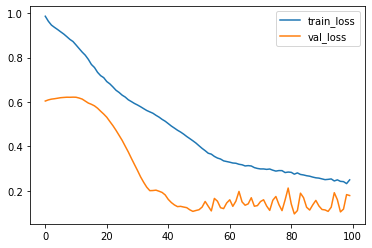

In [266]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

### Plotting the train and test values

3/3 [==============================] - 1s 5ms/step


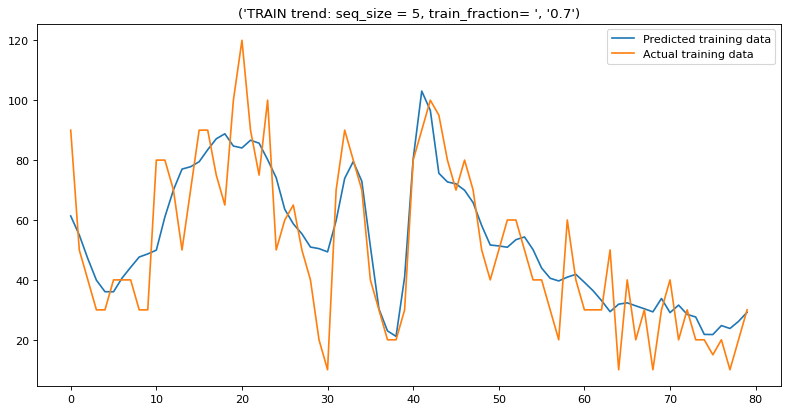

In [267]:
# TRAINING DATA

# Making predictions and taking inverse transform
predicted_train = model.predict(X_train)
actual_train = np.transpose([y_train])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_train = np.repeat(predicted_train, scaled_dataset.shape[1], axis=-1)
actual_train = np.repeat(actual_train, scaled_dataset.shape[1], axis=-1)

predicted_train_inv = scaler.inverse_transform(predicted_train)[:,-1]
actual_train_inv = scaler.inverse_transform(actual_train)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_train_inv, label='Predicted training data')
plt.plot(actual_train_inv, label='Actual training data')
plt.legend()
title = "TRAIN trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

2/2 [==============================] - 0s 7ms/step


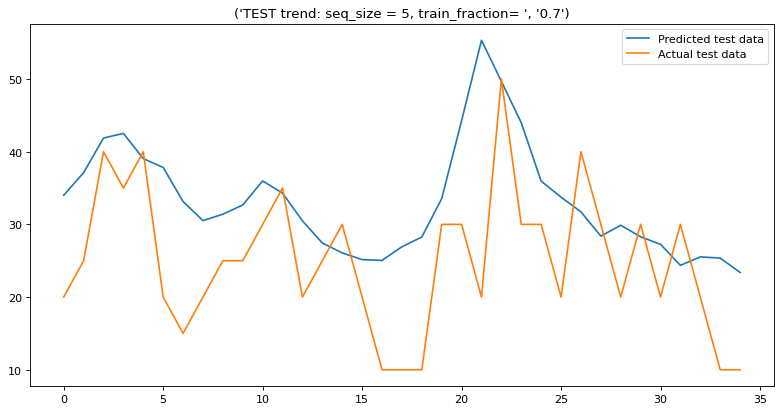

In [268]:
# TEST DATA

# Making predctions and taking inverse transform
predicted_test = model.predict(X_test)
actual_test = np.transpose([y_test])

# IMPORTANT: Reshape the array before scaling: The scaler expects a multidimensional array
predicted_test = np.repeat(predicted_test, scaled_dataset.shape[1], axis=-1)
actual_test = np.repeat(actual_test, scaled_dataset.shape[1], axis=-1)

predicted_test_inv = scaler.inverse_transform(predicted_test)[:,-1]
actual_test_inv = scaler.inverse_transform(actual_test)[:,-1]

# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_test_inv, label='Predicted test data')
plt.plot(actual_test_inv, label='Actual test data')
plt.legend()
title = "TEST trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

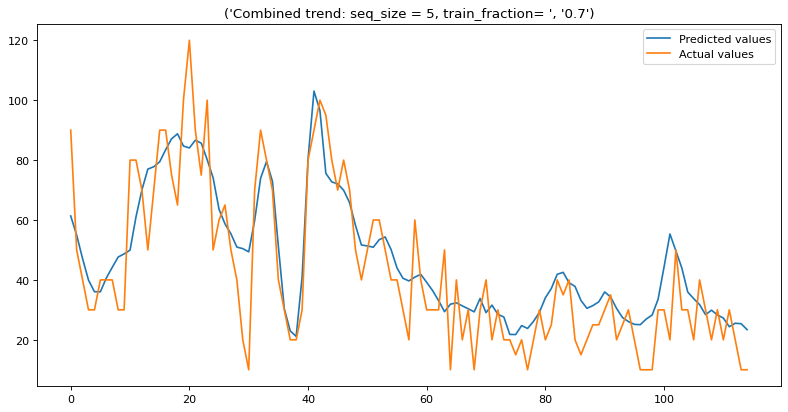

In [269]:
# COMBINED PLOT
# Total loss in datapoints  = 2*(sequence_size + 1)

# Making predctions and taking inverse transform
predicted_combined = np.vstack([predicted_train, predicted_test])
actual_combined = np.vstack([actual_train, actual_test])

predicted_combined_inv = scaler.inverse_transform(predicted_combined)[:, -1]
actual_combined_inv = scaler.inverse_transform(actual_combined)[:, -1]
# Plotting the result
figure(figsize=(12, 6), dpi=80)
plt.plot(predicted_combined_inv, label='Predicted values')
plt.plot(actual_combined_inv, label='Actual values')
plt.legend()
title = "Combined trend: seq_size = "+ str(sequence_size) + ", train_fraction= ", str(train_fraction)
plt.title(title)
plt.show()

### Calculating the R2 score

In [270]:
from sklearn.metrics import r2_score

# Train, test, combined
print("r2 score: ", round(r2_score(actual_train, predicted_train), 3), 
      ", ", round(r2_score(actual_test, predicted_test),3),
      ", ", round(r2_score(actual_combined, predicted_combined),3))

r2 score:  0.741 ,  -0.528 ,  0.741


### Calculating the RMSE
These are calculated on the (Inverse transform) actual biogas values.

In [271]:
# calculate root mean squared error
from sklearn.metrics import mean_squared_error
from math import sqrt

# Train, test, combined
print("RMSE: ", round(sqrt(mean_squared_error(actual_train_inv, predicted_train_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_test_inv, predicted_test_inv)),3),
      ", ", round(sqrt(mean_squared_error(actual_combined_inv, predicted_combined_inv)),3))


RMSE:  13.633 ,  11.818 ,  13.107


### Analysis
**1. Sequence size of 5, train size of 0.7**
1. General trend on train data, Values higher than mean on the test data.
2. r2 score:  0.741 ,  -0.528 ,  0.741
3. RMSE:  13.633 ,  11.818 ,  13.107


